# Topic Modeling


In this Notebook we will analyse the scraped data with different topic modeling algorithms.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import os
import operator
import numpy as np
import pandas as pd
from pprint import pprint
import math
from collections import Counter
from zipfile import ZipFile

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pickle
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
from pyLDAvis import sklearn as sklearn_lda
import seaborn as sns
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

%matplotlib inline

# Enable logging for gensim - optional
import logging
import warnings

# Import the wordcloud library
from wordcloud import WordCloud
import matplotlib.colors as mcolors

# Load the regular expression library
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

from utils import *

logging.basicConfig(
    format="%(asctime)s : %(levelname)s : %(message)s", level=logging.ERROR
)
warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set_style("whitegrid")

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=n

## Load Data

In [3]:
df = pd.read_csv("processed_data.csv", index_col=0)
df.head(2)

,name,location,website,org_type,mission_statement,countries_of_involvement,practice_areas,website_content,error_loading_website,processed_text,lemmatized_text,lemmatized_mission
0,Access to Finance Rwanda,Rwanda,http://www.afr.rw/,Development Organization,low income rwandans especially women youth ben...,Rwanda,"Fragile & Conflict-affected Environments, Gend...",search linkedinin facebookf history work team ...,False,low income rwandans especially women youth ben...,low income rwandans especially women youth ben...,low income rwandans especially women youth ben...
1,AEMFI - Association of Ethiopian Microfinance ...,Ethiopia,http://www.aemfi-ethiopia.org/,"National, Regional, Global Network",enhance capacity microfinance institutions fin...,Ethiopia,Education; Environment & Climate; Financial Co...,NaN,True,enhance capacity microfinance institutions fin...,enhance capacity microfinance institutions fin...,enhance capacity microfinance institutions fin...


## Explore Data

### Most Common Practice Areas

Each of the members is assigned to several practice areas. We take a look at which practice areas are most common among the members.

In [4]:
# Practice area dict
practice_areas = {}

# Add practice areas to dictionary
def count_areas(areas):
    for area in areas:
        if area in practice_areas:
            practice_areas[area] += 1
        else:
            practice_areas[area] = 1

In [5]:
# Convert practice areas string to list of areas
df["practice_areas"] = df["practice_areas"].replace(np.nan, "", regex=True)
df["practice_areas"] = df.apply(
    lambda x: re.sub(r"\([^)]*\)", "", x["practice_areas"]), axis=1
)
df["practice_areas"] = df["practice_areas"].apply(
    lambda x: [area.strip() for area in re.split("; |,", x)]
)
df.apply(lambda x: count_areas(x["practice_areas"]), axis=1)

# Print 10 most commom practice areas
most_common_pratice_areas = dict(
    sorted(practice_areas.items(), key=operator.itemgetter(1), reverse=True)[:10]
)

<AxesSubplot:xlabel='Pratice Areas', ylabel='Frequency'>

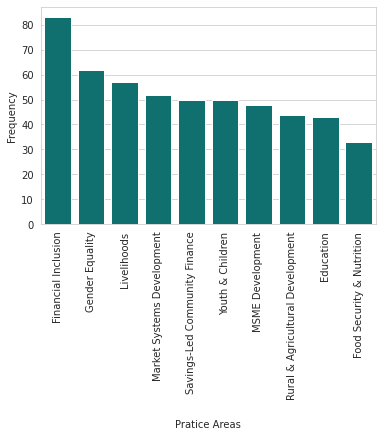

In [6]:
plt.xticks(rotation="vertical")
plt.ylabel("Frequency")
plt.xlabel("Pratice Areas", labelpad=20)
sns.barplot(
    x=list(most_common_pratice_areas.keys()),
    y=list(most_common_pratice_areas.values()),
    color="teal",
)

The most common pratice ares is financial inclusion.

### Word Cloud

To determine the most common words, we a Wordcloud. 

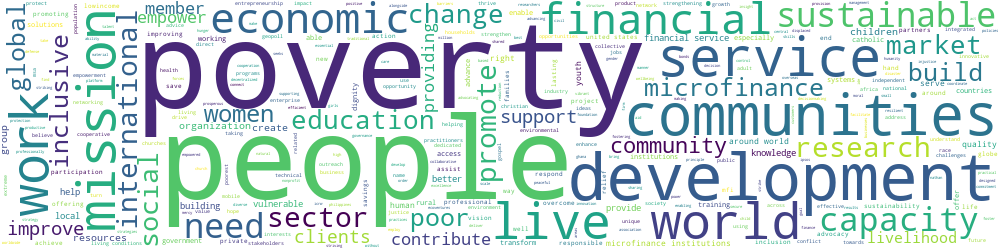

In [7]:
# Mission Statements
generate_word_cloud(df["lemmatized_mission"]).to_image()

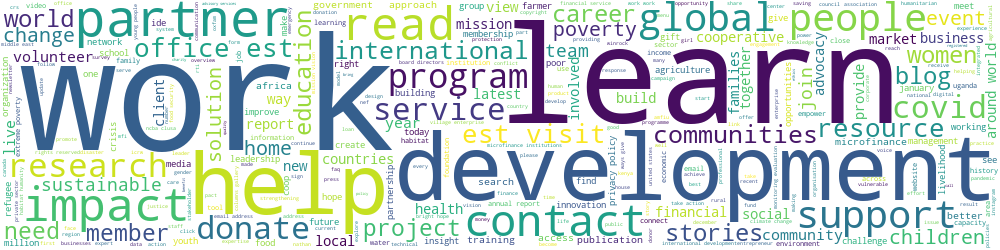

In [8]:
# Mission Statements + Website Content
generate_word_cloud(df["lemmatized_text"]).to_image()

### 10 Most Common Words

We also plot the 10 most common words in the mission statements and the combination of mission statement and website content.

In [9]:
def plot_most_common_words(pd_series):
    import collections

    long_string = ",".join(list(pd_series.values))
    word_counter = collections.Counter(long_string.split(" "))
    most_common = word_counter.most_common(10)
    plt.xticks(rotation="vertical")
    plt.ylabel("Counts")
    plt.xlabel("Words", labelpad=20)
    sns.barplot(
        x=[x[0] for x in most_common], y=[y[1] for y in most_common], color="teal"
    )

#### Only Mission statement

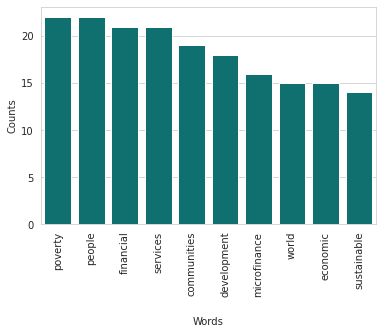

In [10]:
# Add function again for remove duplicates and plot most common words

plot_most_common_words(df["lemmatized_mission"])
# plot_most_common_words(df["lemmatized_mission"], rmv_duplicates=True)

#### Mission Statement + Website Content

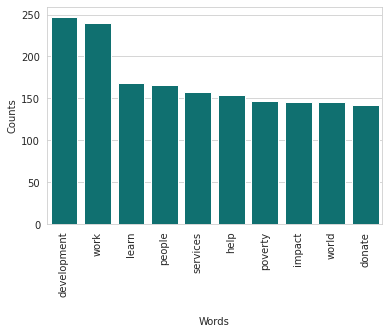

In [11]:
plot_most_common_words(df["lemmatized_text"])
# plot_most_common_words(df["lemmatized_text"], rmv_duplicates=True)

## Topic Modeling

In order to get an even better understanding of the members mission, we use the Latent Dirichlet allocation algorithm. This method groups words into topics and rank the words according to their probability.

In [12]:
max_number_of_topics = 15
min_number_of_topics = 2

topic_range = range(min_number_of_topics, max_number_of_topics + 1)

### Sklearn LDA

We try LDA models with different number of topics and print the 10 most common words in those topics. We evaluate the LDA models with Perplexity. A model with lower perplexity is preferred.

We also tried a Python library for interactive topic model visualization called pyLDAvis.

#### On mission statement

As text we first only use the mission statement.

In [13]:
# Initialise the count vectorizer with the English stop words
count_vectorizer_mission = CountVectorizer(stop_words="english")
# Fit and transform the processed titles
count_data_mission = count_vectorizer_mission.fit_transform(df["lemmatized_mission"])
# Generates LDA models for 1 to 10 topics
lda_models_mission, lda_perplexity_mission = generate_lda_models(
    topic_range, count_data_mission
)

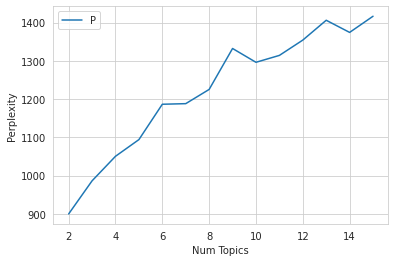

In [14]:
# have here the different models next to each other
plt.plot(topic_range, lda_perplexity_mission)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity")
plt.legend(("Perplexity"), loc="best")
plt.show()

The lowest perplexity value can be found for 2 topics. 

In [15]:
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_models_mission[0], count_vectorizer_mission, 10)

Topics found via LDA:

Topic #1:
services financial development microfinance economic research poverty capacity education institutions

Topic #2:
communities people poverty world mission lives market change sustainable women


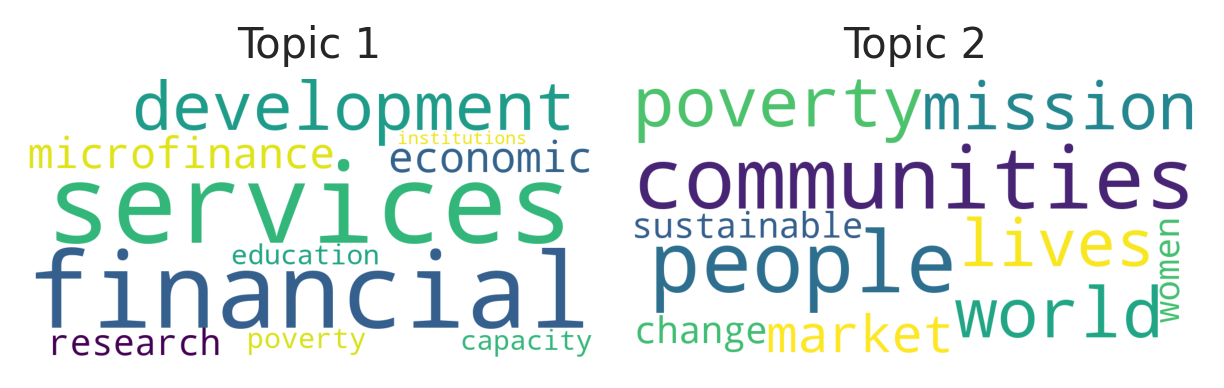

In [16]:
plot_topic_word_cloud(lda_models_mission[0], count_vectorizer_mission, (1, 2))
# TODO: change weighting

In [17]:
# Mission statement
LDAvis_prepared = sklearn_lda.prepare(
    lda_models_mission[0], count_data_mission, count_vectorizer_mission
)
pyLDAvis.enable_notebook()
# pyLDAvis.show(LDAvis_prepared)
pyLDAvis.display(LDAvis_prepared)

#### On mission statement + website content

In addition we also trained LDAs on the website content corpus plus mission statement. 

In [18]:
# Initialise the count vectorizer with the English stop words
count_vectorizer_text = CountVectorizer(stop_words="english")
# Fit and transform the processed titles
count_data_text = count_vectorizer_text.fit_transform(df["lemmatized_text"])
# Generates LDA models for 1 to 10 topics
lda_models_text, lda_perplexity_text = generate_lda_models(topic_range, count_data_text)

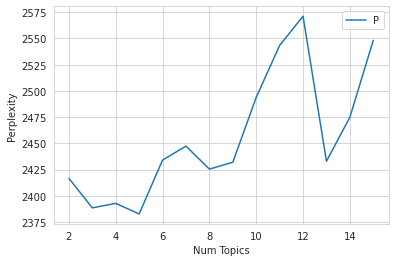

In [19]:
# have here the different models next to each other
plt.plot(topic_range, lda_perplexity_text)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity")
plt.legend(("Perplexity"), loc="best")
plt.show()

The lowest perplexity value can be found for 12 topics. 

In [20]:
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_models_text[10], count_vectorizer_text, 10)

Topics found via LDA:

Topic #1:
crs help people work learn catholic donate home change featured

Topic #2:
microfinance financial members services columns institutions association sector gallery finance

Topic #3:
visit office est global oxfam communities learn nacopha world work

Topic #4:
development research business rti work people partners solutions global health

Topic #5:
hope amfiu bright contact world research diaries team international post

Topic #6:
habitat ide donate women work read support learn water people

Topic #7:
work children learn help poverty care donate read icrw financial

Topic #8:
grameen poverty poor people donate covid help hasal development effect

Topic #9:
development program education pakistan services fhi opportunities partners careers programs

Topic #10:
pact development sector ama building capacity services stakeholders management institutions

Topic #11:
tweet home yfoundation gmw better yfondation fao smile gmwchallenge communityactivate

Topic #

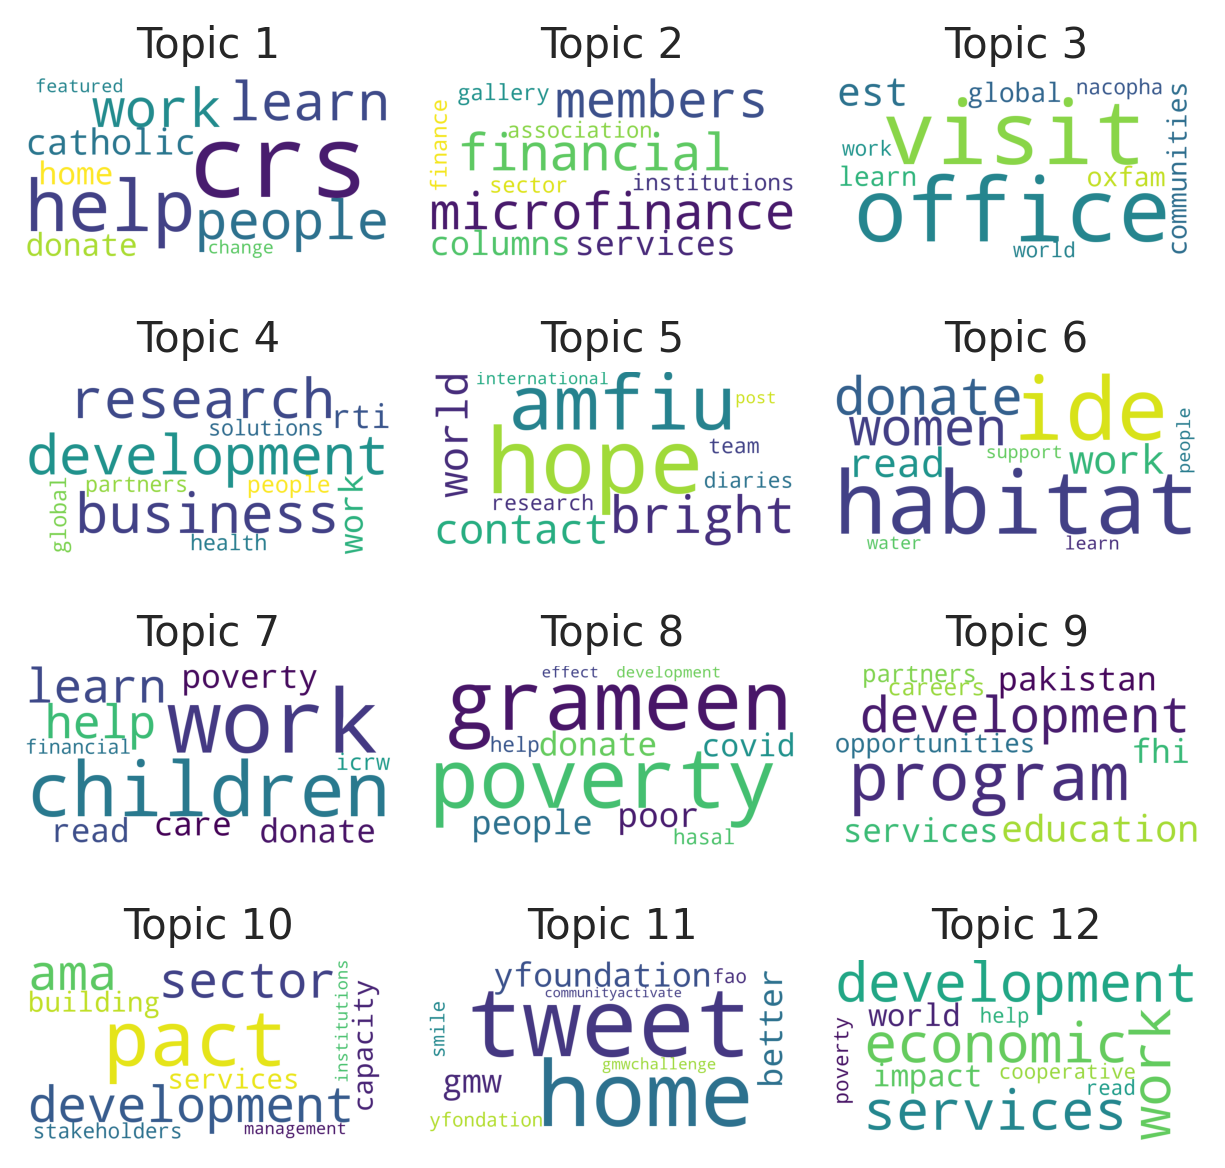

In [21]:
plot_topic_word_cloud(lda_models_text[10], count_vectorizer_text, (4, 3))
# TODO: change weighting

In [32]:
# Mission statement + website content

LDAvis_prepared = sklearn_lda.prepare(
    lda_models_text[10], count_data_text, count_vectorizer_text
)
pyLDAvis.enable_notebook()
# pyLDAvis.show(LDAvis_prepared)
pyLDAvis.display(LDAvis_prepared)

# from IPython.core.display import HTML
# HTML(viz)

### LDAMallet

There are many other approaches to evaluate Topic models such as Perplexity, but its poor indicator of the quality of the topics. Topic Coherence measure is a good way to compare difference topic models based on their human-interpretability. Coherence measures the relative distance between words within a topic. Sklearn doesn't support the calculation of the coherence measure. This is why we also tried out LDA mallet. Then we tried LDA mallet. Mallet uses Gibbs Sampling which is more precise than Gensim's faster and online Variational Bayes. 

#### Model

In [23]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
zf = ZipFile("mallet-2.0.8.zip")
zf.extractall()

os.environ['MALLET_HOME'] = os.path.join(cwd, "mallet-2.0.8/")

--2021-02-28 22:26:58--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip.1’

mallet-2.0.8.zip.1  100%[===================>]  15.43M  3.10MB/s    in 6.8s    

2021-02-28 22:27:05 (2.29 MB/s) - ‘mallet-2.0.8.zip.1’ saved [16184794/16184794]



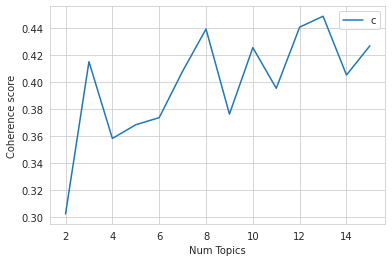

In [24]:
# Can take a long time to run.
texts = list(sent_to_words(df["lemmatized_text"]))
id2word = corpora.Dictionary(texts)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

models, coherence_value = compute_coherence_values(
    dictionary=id2word, corpus=corpus, texts=texts, canditates=topic_range
)
plt.plot(topic_range, coherence_value)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc="best")
plt.show()

According to the graph, 8 or 13 would be good numbers to choose from since their coherence scores are the highest.

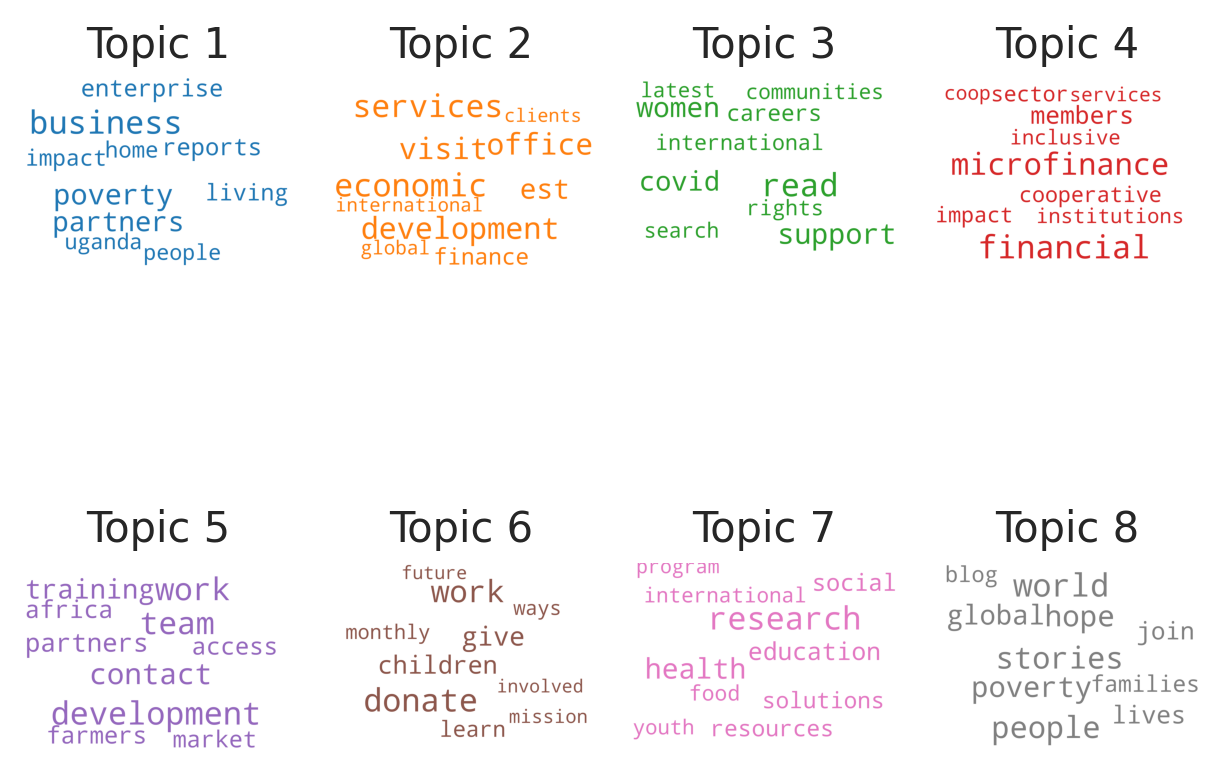

In [33]:
# 4 topics

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(
    background_color="white",
    width=2500,
    height=1800,
    max_words=10,
    colormap="tab10",
    color_func=lambda *args, **kwargs: cols[i],
    prefer_horizontal=1.0,
)

topics = models[6].show_topics(num_topics=9, num_words=10, formatted=False)
fig, axes = plt.subplots(2, 4, figsize=(5, 5), sharex=True, sharey=True, dpi=250)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title("Topic " + str(i + 1), fontdict=dict(size=12))
    plt.gca().axis("off")


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis("off")
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#### TSNE

We use TSNE to find out whether similar documents are plotted close by in a low dimensional space (similar to pyLDAvis)

In [34]:
n_topics = 8
lda_model = models[n_topics - 2]
# Getting topic weights

topic_weights = []
tops = lda_model[corpus]
for i, row_list in enumerate(tops):
    topic_weights.append([w for i, w in row_list])
# Generating an array of optic weights
arr = pd.DataFrame(topic_weights).fillna(0).values
# Dominant topic in each document
topic_num = np.argmax(arr, axis=1)
# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=0.99, init="pca")
tsne_lda = tsne_model.fit_transform(arr)
# Plotting the Topic Clusters with Bokeh
output_notebook()

mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(
    title="t-SNE Clustering of {} LDA Topics".format(n_topics),
    plot_width=900,
    plot_height=700,
)
plot.scatter(x=tsne_lda[:, 0], y=tsne_lda[:, 1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 96 samples in 0.000s...
[t-SNE] Computed neighbors for 96 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 96 / 96
[t-SNE] Mean sigma: 0.146078
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.787277
[t-SNE] KL divergence after 1000 iterations: 0.167898


Loading BokehJS ...

## Documents to Topic

In addition to creating segments, we now also want to assign each document to the most appropriate topic. 

In [35]:
# Main topic per document
assign_topic = np.array(topic_weights)
print(assign_topic.shape)
main_topic_per_document = np.argmax(assign_topic, axis=1)

(96, 8)


### Save Topics

Final 9 topics. 

In [37]:
topics = models[6].show_topics(formatted=False)
for top in topics:
    array = np.transpose(top[1])
    print(" ".join(wrd for wrd in array[0]))

business poverty partners reports enterprise living impact home people uganda
economic services development visit office est finance global international clients
read support women covid careers international rights communities search latest
financial microfinance members cooperative sector impact institutions inclusive coop services
development team work contact training partners africa access farmers market
donate work give children learn monthly ways mission future involved
research health education social resources solutions food international youth program
world stories people hope poverty global lives join families blog


In [49]:
df_topics = pd.DataFrame(topics, columns=["topic_index", "topic_words"]).set_index(
    "topic_index"
)
df_topics

,topic_words
topic_index,
0,"[(business, 0.025308025308025308), (poverty, 0..."
1,"[(economic, 0.0344542447629548), (services, 0...."
2,"[(read, 0.030115830115830116), (support, 0.023..."
3,"[(financial, 0.03020227209753394), (microfinan..."
4,"[(development, 0.02041387024608501), (team, 0...."
5,"[(donate, 0.03628929210324559), (work, 0.03347..."
6,"[(research, 0.03051643192488263), (health, 0.0..."
7,"[(world, 0.026906936558874352), (stories, 0.02..."


In [50]:
df_topics.to_csv("topics.csv")

### Save DataFrame with Topic Index

In [36]:
# Add topic to DataFrame
df["Topic_index"] = main_topic_per_document
df["count_text"] = df["lemmatized_text"].str.len()
res = df.sort_values(["count_text", "Topic_index"], ascending=[True, True])
res.to_csv("results.csv")

In [30]:
name_topic = df.groupby("Topic_index")["name"].apply(list)

Each row is a list of the stakeholders that can (most) be repensented by the topic(recording the row index) 

In [31]:
tmp = list(name_topic)
for i, names in enumerate(tmp):
    s = ", "
    print(
        f"{str(len(names))} Organisations in Topic {i}:\n{s.join(name for name in names)} \n"
    )

19 Organisations in Topic 0:
AEMFI - Association of Ethiopian Microfinance Institutions, AMA - Afghanistan Microfinance Association, AMIR - Association of Micro Finance Institutions in Rwanda, CAM - China Association of Microfinance, CDF - Credit and Development Forum, CMFA - Caribbean Microfinance Alliance, CSD Nepal, DevLearn, EcoVentures International, FSD Zambia, Itad Ltd, Making Cents International, MarketShare Associates, MaTontine, Nathan Associates, ProDesarrollo, Finanzas y Microempresa, RIM Burundi - Réseau des Institutions de Microfinance au Burundi, World Vision International, YFoundation 

32 Organisations in Topic 1:
Aga Khan Foundation USA, AMFA - Azerbaijan Micro-Finance Association, CARE USA, Chemonics International, CRS - Catholic Relief Services, FHI 360, GeoPoll, Global Communities, Grameen Foundation, Heifer International, Hope International, ICCO Cooperation, iDE - International Development Enterprises, IDRC - International Development Research Centre, Land O'Lake